# **Increment and decrement**

In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, QuantumRegister, ClassicalRegister, execute, BasicAer
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [2]:
import math
%matplotlib inline

In [3]:
# Set up the program
a = QuantumRegister(4, name='a')
scratch = QuantumRegister(1, name='scratch')
qc = QuantumCircuit(a, scratch)

In [4]:
def main():
    ## initialization
    qc.x(a[0])
    qc.h(a[2])
    qc.rz(math.radians(45), a[2])
    qc.barrier()
    
    ## Increment
    add_int(a, 1)
    qc.barrier()
    ## Decrement
    add_int(a, -1)

In [5]:
###############################################
## Some utility functions

def add_int(qdest, rhs):
    reverse_to_subtract = False
    if rhs == 0:
        return
    elif rhs < 0:
        rhs = -rhs
        reverse_to_subtract = True
    ops = []
    add_val = int(rhs)
    condition_mask = (1 << len(qdest)) - 1

    add_val_mask = 1
    while add_val_mask <= add_val:
        cmask = condition_mask & ~(add_val_mask - 1)
        if add_val_mask & add_val:
            add_shift_mask = 1 << (len(qdest) - 1)
            while add_shift_mask >= add_val_mask:
                cmask &= ~add_shift_mask
                ops.append((add_shift_mask, cmask))
                add_shift_mask >>= 1
        condition_mask &= ~add_val_mask
        add_val_mask <<= 1
    if reverse_to_subtract:
        ops.reverse()
    for inst in ops:
        op_qubits = []
        mask = 1
        for i in range(len(qdest)):
            if inst[1] & (1 << i):
                op_qubits.append(qdest[i])
        for i in range(len(qdest)):
            if inst[0] & (1 << i):
                op_qubits.append(qdest[i])
        multi_cx(op_qubits)

In [6]:
def multi_cz(qubits):
    ## This will perform a CCCCCZ on as many qubits as we want,
    ## as long as we have enough scratch qubits
    multi_cx(qubits, do_cz=True)

In [7]:
def multi_cx(qubits, do_cz=False):
    ## This will perform a CCCCCX with as many conditions as we want,
    ## as long as we have enough scratch qubits
    ## The last qubit in the list is the target.
    target = qubits[-1]
    conds = qubits[:-1]
    scratch_index = 0
    ops = []
    while len(conds) > 2:
        new_conds = []
        for i in range(len(conds)//2):
            ops.append((conds[i * 2], conds[i * 2 + 1], scratch[scratch_index]))
            new_conds.append(scratch[scratch_index])
            scratch_index += 1
        if len(conds) & 1:
            new_conds.append(conds[-1])
        conds = new_conds
    for op in ops:
        qc.ccx(op[0], op[1], op[2])
    if do_cz:
        qc.h(target)
    if len(conds) == 0:
        qc.x(target)
    elif len(conds) == 1:
        qc.cx(conds[0], target)
    else:
        qc.ccx(conds[0], conds[1], target)
    if do_cz:
        qc.h(target)
    ops.reverse()
    for op in ops:
        qc.ccx(op[0], op[1], op[2])

main()

In [8]:
## That's the program. Everything below runs and draws it.

backend = BasicAer.get_backend('statevector_simulator')
job = execute(qc, backend)
result = job.result()

|1> (0.653-0.271j)
|5> (0.653+0.271j)


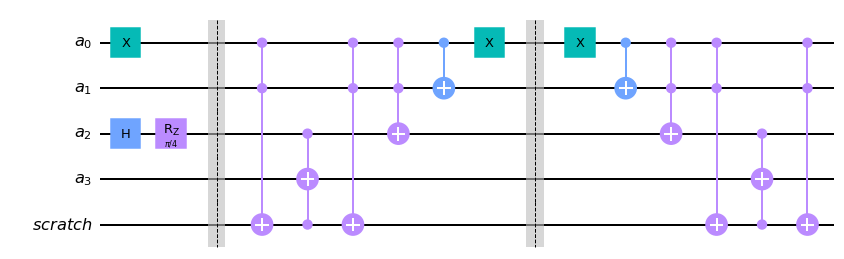

In [9]:
outputstate = result.get_statevector(qc, decimals=3)
for i,amp in enumerate(outputstate):
    if abs(amp) > 0.000001:
        print('|{}> {}'.format(i, amp))
qc.draw()        # draw the circuit